<a href="https://colab.research.google.com/github/Prathyusha-Akundi/Skin-Classification/blob/main/multiscale_input_featurewiseNorm_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install -q kaggle
# from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Upwork/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download shonenkov/isic2018
! mkdir isic2018
! unzip isic2018.zip -d isic2018

Streaming output truncated to the last 5000 lines.
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029323.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029324.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029325.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029326.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029327.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029328.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029329.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029330.jpg  
  inflating: isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0029331.jpg  
  inflating: isic2018/ISIC2018_Task3_Tra

In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D 
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Model


filterwarnings('ignore')
np.random.seed(101)
EFNS = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, 
        EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]

In [3]:
root_path = '/content/isic2018/'
IMAGE_DIR = ( '/content/isic2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input')
panda_path = os.path.join(root_path, 'ISIC2018_Task3_Training_GroundTruth.csv')
print(len(os.listdir(IMAGE_DIR)))
#os.path.join

10017


In [4]:
def preprocess(df):
    for index, img in enumerate(df.image):
        img = img+'.jpg'
        df.image[index]=img
    # df.drop(['UNK'], axis=1, inplace=True)

In [5]:
def train_val_test_split(df, test_len=1000, val_ratio=0.2):
    test_rows = (np.random.rand(1000)*df.shape[0]).astype(int)
    test_df =  df.iloc[test_rows]
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df.drop(test_rows, axis=0, inplace=True)
    df = df.reset_index().drop(['index'], axis=1)
    val_rows = (np.random.rand(int(val_ratio*df.shape[0]))*df.shape[0]).astype(int)
    val_df = df.iloc[val_rows]
    df.drop(val_rows, axis=0, inplace=True)
    val_df = val_df.reset_index().drop(['index'], axis=1)
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df = df.reset_index().drop(['index'], axis=1)
#     int_dict = {'MEL':int, 'NV':int, 'BCC':int, 'AK':int, 'BKL':int, 'DF':int, 'VASC':int, 'SCC':int}
#     df = df.astype(int_dict) 
#     val_df = val_df.astype(int_dict)
#     test_df = test_df.astype(int_dict)
    return df, val_df, test_df

In [6]:
full_df = pd.read_csv(panda_path)
preprocess(full_df)
train_df, val_df, test_df = train_val_test_split(full_df)
labels=list(train_df.columns[1:])
print(labels)
train_df.head()

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024312.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.mean(labels, axis=0)
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [8]:
labels = list(train_df.columns)[1:]

In [9]:
def get_segmentation_model(weights_path, inputs=None):
  # Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
  INPUT_CHANNELS = 3
  # Number of output masks (1 in case you predict only one type of objects)
  OUTPUT_MASK_CHANNELS = 1
  # Pretrained weights
  def double_conv_layer(x, size, dropout=0.40, batch_norm=True, name = None):
    
    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same',name=name)(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

  dropout_val=0.50
    
  if inputs is None:  
    inputs = Input((256, 256, INPUT_CHANNELS))
  axis = 3
  filters = 32

  conv_256 = double_conv_layer(inputs, filters)
  pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_256)

  conv_112 = double_conv_layer(pool_112, 2*filters)
  pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

  conv_56 = double_conv_layer(pool_56, 4*filters)
  pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

  conv_28 = double_conv_layer(pool_28, 8*filters)
  pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

  conv_14 = double_conv_layer(pool_14, 16*filters)
  pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

  conv_7 = double_conv_layer(pool_7, 32*filters, name='features')

  up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
  up_conv_14 = double_conv_layer(up_14, 16*filters)

  up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
  up_conv_28 = double_conv_layer(up_28, 8*filters)

  up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
  up_conv_56 = double_conv_layer(up_56, 4*filters)

  up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
  up_conv_112 = double_conv_layer(up_112, 2*filters)

  up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_256], axis=axis)
  up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

  conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
  conv_final = Activation('sigmoid')(conv_final)
  pred = Reshape((256,256))(conv_final)
  model = Model(inputs, pred, name="UNET_256")
  model.load_weights(weights_path)
  return model

In [10]:
segmentation_weights = '/content/drive/MyDrive/Upwork/Skin Classification/segmentation_weights/segmentation_256_unet_final'
segmentator = get_segmentation_model(weights_path=segmentation_weights)
segmentator.trainable = False

In [11]:
target_w = 256
target_h = 256

def crop_mask_prep(im):
    im = np.reshape(im,(1,target_w,target_h,3))
    im = im*(1./255)
    mask = segmentator.predict(im)
    im = np.squeeze(im)
    mask = np.squeeze(mask)
    mask_ = np.dstack((mask,mask,mask))
    mask_ = np.uint8(mask_*255)
    try:
        maskgray = cv2.cvtColor(mask_,cv2.COLOR_BGR2GRAY)
        ret,thresh = cv2.threshold(maskgray,127,255,cv2.THRESH_BINARY)
        # find contours 
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(contour) for contour in contours]
        cnt = contours[np.argmax(areas)]
        # straight rectangle
        x,y,w,h = cv2.boundingRect(cnt)
        final = im[y:y+h, x:x+w]
        final = cv2.resize(final, (target_w,target_h))
        final = np.uint8(final*255)
    except:
        final = np.uint8(im*255)

    
    return final

In [12]:
def get_generator(df=train_df, image_dir=IMAGE_DIR, x_col='image', y_cols=labels, shuffle=True, batch_size=32, seed=42, target_w = 256, target_h = 256):
    
    
    print("getting  generator...") 
    # normalize images
    image_generator1 = ImageDataGenerator(
        # rescale=1./255,  
        featurewise_center = True,
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 15,
#         preprocessing_function = preprocessing
        # samplewise_center=True,
        # samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator1 = image_generator1.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    image_generator2 = ImageDataGenerator(
        # rescale=1./255,  
        featurewise_center = True,
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 15,
        preprocessing_function = crop_mask_prep
        # samplewise_center=True,
        # samplewise_std_normalization= True
        )
    
    # flow from directory with specified batch size
    # and target image size
    generator2= image_generator2.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    while True:
        X1i = generator1.next()
        X2i = generator2.next()
        yield [X1i[0], X2i[0]], X2i[1]

In [13]:
batch_size = 32
train_generator = get_generator(df = train_df, batch_size = batch_size)
valid_generator = get_generator(df = val_df, batch_size = batch_size)
test_generator = get_generator(df = test_df, batch_size = batch_size)

In [14]:
class_labels = train_df[labels].values
class_labels.shape

(7421, 7)

In [15]:
freq_pos, freq_neg = compute_class_freqs(class_labels)

pos_weights = freq_neg
neg_weights = freq_pos

In [16]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    
    return weighted_loss

In [17]:
x, y = next(train_generator)

getting  generator...
Found 7421 validated image filenames.
Found 7421 validated image filenames.


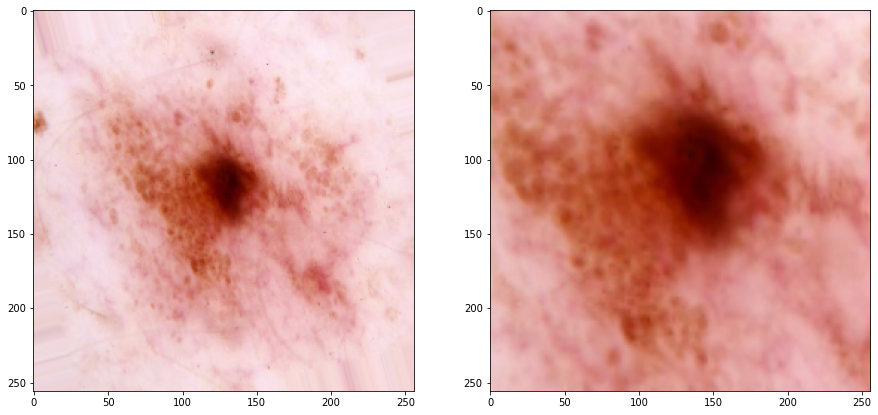

In [18]:
i = 8
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [19]:
(np.max(x[0][i]),np.max(x[1][i]))

(255.0, 254.0)

In [20]:
x, y = next(valid_generator)


getting  generator...
Found 1814 validated image filenames.
Found 1814 validated image filenames.


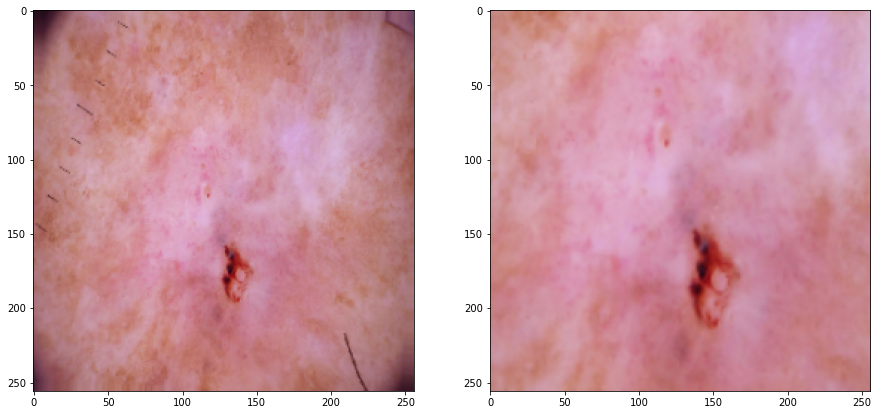

In [21]:
i = 9
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [22]:
(np.max(x[0][i]),np.max(x[1][i]))

(232.99632, 230.0)

getting  generator...
Found 1000 validated image filenames.
Found 1000 validated image filenames.


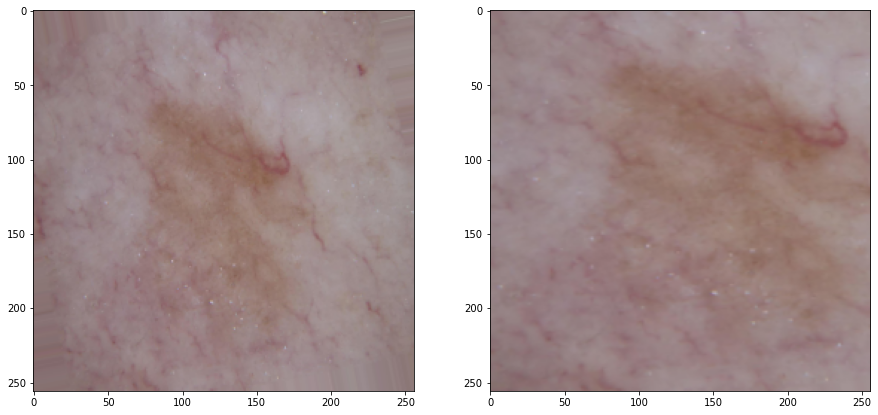

In [23]:
x, y = next(test_generator)

i = 10
f,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(np.uint8(x[0][i]))
ax[1].imshow(np.uint8(x[1][i]))

In [24]:
(np.max(x[0][i]),np.max(x[1][i]))

(214.54875, 205.0)

In [25]:
def get_classifier_model(labels,dim = 256, ef = 0):
    ### Base Model ###
    # Input
    
    input1 = Input(shape = (dim, dim, 3))
    input2 = Input(shape = (dim, dim, 3))
    # Base EfficientNet pretrained model
    base = EFNS[ef](
        input_shape = (dim, dim, 3),
        weights = "imagenet",
        include_top = False,
        # pooling = 'avg'
    )
    x1 = base(input1)    
    x1 = Conv2D(512, (3, 3), padding='same',name='effnet_features1', activation = "relu")(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    # x1 = tf.keras.layers.GlobalAveragePooling2D(name='effnet_features1')(x1)
    
    x2 = base(input2)
    x2 = Conv2D(512, (3, 3), padding='same',name='effnet_features2', activation = "relu")(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
    # x2 = tf.keras.layers.GlobalAveragePooling2D(name='effnet_features2')(x2)
    
    x = tf.keras.layers.Concatenate()([x1,x2])
    # x = ReLU()(x)
    # x = Dense(512, activation = "relu")(x)
    # x = Dropout(0.2)(x)

    x = Dense(128, activation = "relu")(x)
   
    
    # x = base(inputs)
    # x = Conv2D(1024, (3, 3), padding='same',name='effnet_features')(x)
    # x = tf.keras.layers.GlobalAveragePooling2D()(x1)

    ### Rebuild top ###
    x = Dense(labels, activation = "sigmoid")(x)


    model = Model(inputs = [input1, input2], outputs = x)
    model.compile(optimizer= 'adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=[tf.keras.metrics.AUC(from_logits=False)])
    return model

In [26]:
model = get_classifier_model(len(labels))

16719872/16705208 [==============================] - 0s 0us/step


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 8, 8, 1280)   4049571     ['input_2[0][0]',                
                                                                  'input_3[0][0]']            

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, verbose=1)
checkpoint_filepath = '/content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0_2018'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    verbose = 1,
    save_best_only=True)

In [29]:
STEP_SIZE_TRAIN=len(train_df)//batch_size
STEP_SIZE_VALID= len(val_df)//batch_size
STEP_SIZE_TEST=len(test_df)//batch_size

In [30]:

history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,verbose=1,
                        validation_steps=STEP_SIZE_VALID, epochs=25, callbacks=[callback, model_checkpoint_callback])

Epoch 1/25
231/231 [==============================] - ETA: 0s - loss: 0.4733 - auc: 0.8698
Epoch 00001: val_auc improved from -inf to 0.82470, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0_2018
231/231 [==============================] - 1096s 5s/step - loss: 0.4733 - auc: 0.8698 - val_loss: 0.4699 - val_auc: 0.8247
Epoch 2/25
231/231 [==============================] - ETA: 0s - loss: 0.3884 - auc: 0.9083
Epoch 00002: val_auc improved from 0.82470 to 0.93283, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0_2018
231/231 [==============================] - 1064s 5s/step - loss: 0.3884 - auc: 0.9083 - val_loss: 0.4295 - val_auc: 0.9328
Epoch 3/25
231/231 [==============================] - ETA: 0s - loss: 0.3339 - auc: 0.9381
Epoch 00003: val_auc improved from 0.93283 to 0.94211, saving model to /content/drive/MyDrive/Upwork/Skin Classification/models/multiscale_input_B0_2018
231/231 [================

In [31]:
model.load_weights(checkpoint_filepath)

In [32]:
loss, val_auc = model.evaluate_generator(valid_generator,steps=STEP_SIZE_VALID,verbose=1)
print(val_auc)

56/56 [==============================] - 198s 4s/step - loss: 0.3509 - auc: 0.9724
0.9723823070526123


In [33]:
test_loss, test_auc = model.evaluate_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
print(test_auc)

31/31 [==============================] - 108s 4s/step - loss: 0.3441 - auc: 0.9740
0.9739760160446167
